In [1]:
# Install Dependencies

# !pip install spotipy, pandas, numpy, sklearn, matplotlib, seaborn, kneed

In [2]:
import sys
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from kneed import KneeLocator
sns.set()

## Spotipy Credentials and API Calls

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
## Set Spotipy credentials

username = 'anmolmishra1999@gmail.com'
client_id = os.getenv('SPOTIPY_CLIENT_ID')
client_secret = os.getenv('SPOTIPY_CLIENT_SECRET')
redirect_uri = os.getenv('SPOTIPY_REDIRECT_URI')      

In [5]:
# Initialize Spotify API token

token = util.prompt_for_user_token(username, scope='playlist-read-private', client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
sp = spotipy.Spotify(auth=token)

In [6]:
# A function to extract track names and URIs from a playlist

def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [7]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):
  
    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

In [8]:
# Set DF column names
df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])

## Importing Spotify playlist

In [9]:
df = get_features_for_playlist(df, username, 'spotify:playlist:3uFoFOG2iR7r3DubKjeqVK')

# Display dataframe
df

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,Talibans,Byron Messia,spotify:track:0TTOsyDKykWhCh3qDd9wMY,0.571000,0.929,0.430,0.000000,0.1020,-9.387,0.2060,103.010,0.498,ATSMC
1,Gbona,Burna Boy,spotify:track:7rpWDu9GPlLxbLorYKVys7,0.564000,0.798,0.813,0.000142,0.1080,-5.869,0.1620,93.912,0.942,ATSMC
2,"PAMI (feat. Wizkid, Adekunle Gold & Omah Lay)",DJ Tunez,spotify:track:6iC4xfqow6iAsRhPh5IrWz,0.625000,0.755,0.645,0.000006,0.1970,-6.933,0.0944,99.889,0.695,ATSMC
3,Pull Up,Koffee,spotify:track:6eydzKn9vLC57U9iToAwJD,0.316000,0.810,0.604,0.051400,0.0944,-3.296,0.0904,102.937,0.646,ATSMC
4,Ginger (feat. Burna Boy),Wizkid,spotify:track:51mLQ3w7yR7vjdSTFLWaY5,0.103000,0.545,0.749,0.000000,0.2320,-6.621,0.1530,100.503,0.681,ATSMC
5,Blood and Thunder,Mastodon,spotify:track:3jagGO7eHHuaD53ibehkux,0.000009,0.364,0.935,0.729000,0.0317,-6.548,0.0724,92.717,0.478,ATSMC
6,Laid to Rest,Lamb of God,spotify:track:1yc53HK08sDab7PDFgnLWk,0.000293,0.366,0.956,0.004470,0.4490,-3.725,0.1080,104.016,0.159,ATSMC
7,Re-Crucified,Revocation,spotify:track:2bJGjDcYtSPt2YVZVh3G95,0.000113,0.499,0.992,0.000265,0.2120,-4.876,0.1390,111.518,0.074,ATSMC
8,Lifestalker,Cattle Decapitation,spotify:track:7Apb2x5qHdEEO7SG8f5uH9,0.000019,0.323,0.986,0.568000,0.3080,-3.612,0.1700,115.107,0.224,ATSMC
9,As Grace Descends,Suffocation,spotify:track:6mkGQ9tHzVUVQidmt6gM3y,0.000009,0.417,0.982,0.506000,0.3720,-4.609,0.1800,105.962,0.200,ATSMC


In [10]:
# Switch this
df['tempo'][19] = df['tempo'][19]/2

# Add category labels
categories = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]
df['categories'] = categories

/var/folders/_x/qvdcsqp97r92fzdmk4t_7wh00000gn/T/ipykernel_39745/1497063640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tempo'][19] = df['tempo'][19]/2


Isolate the features we want to use for clustering

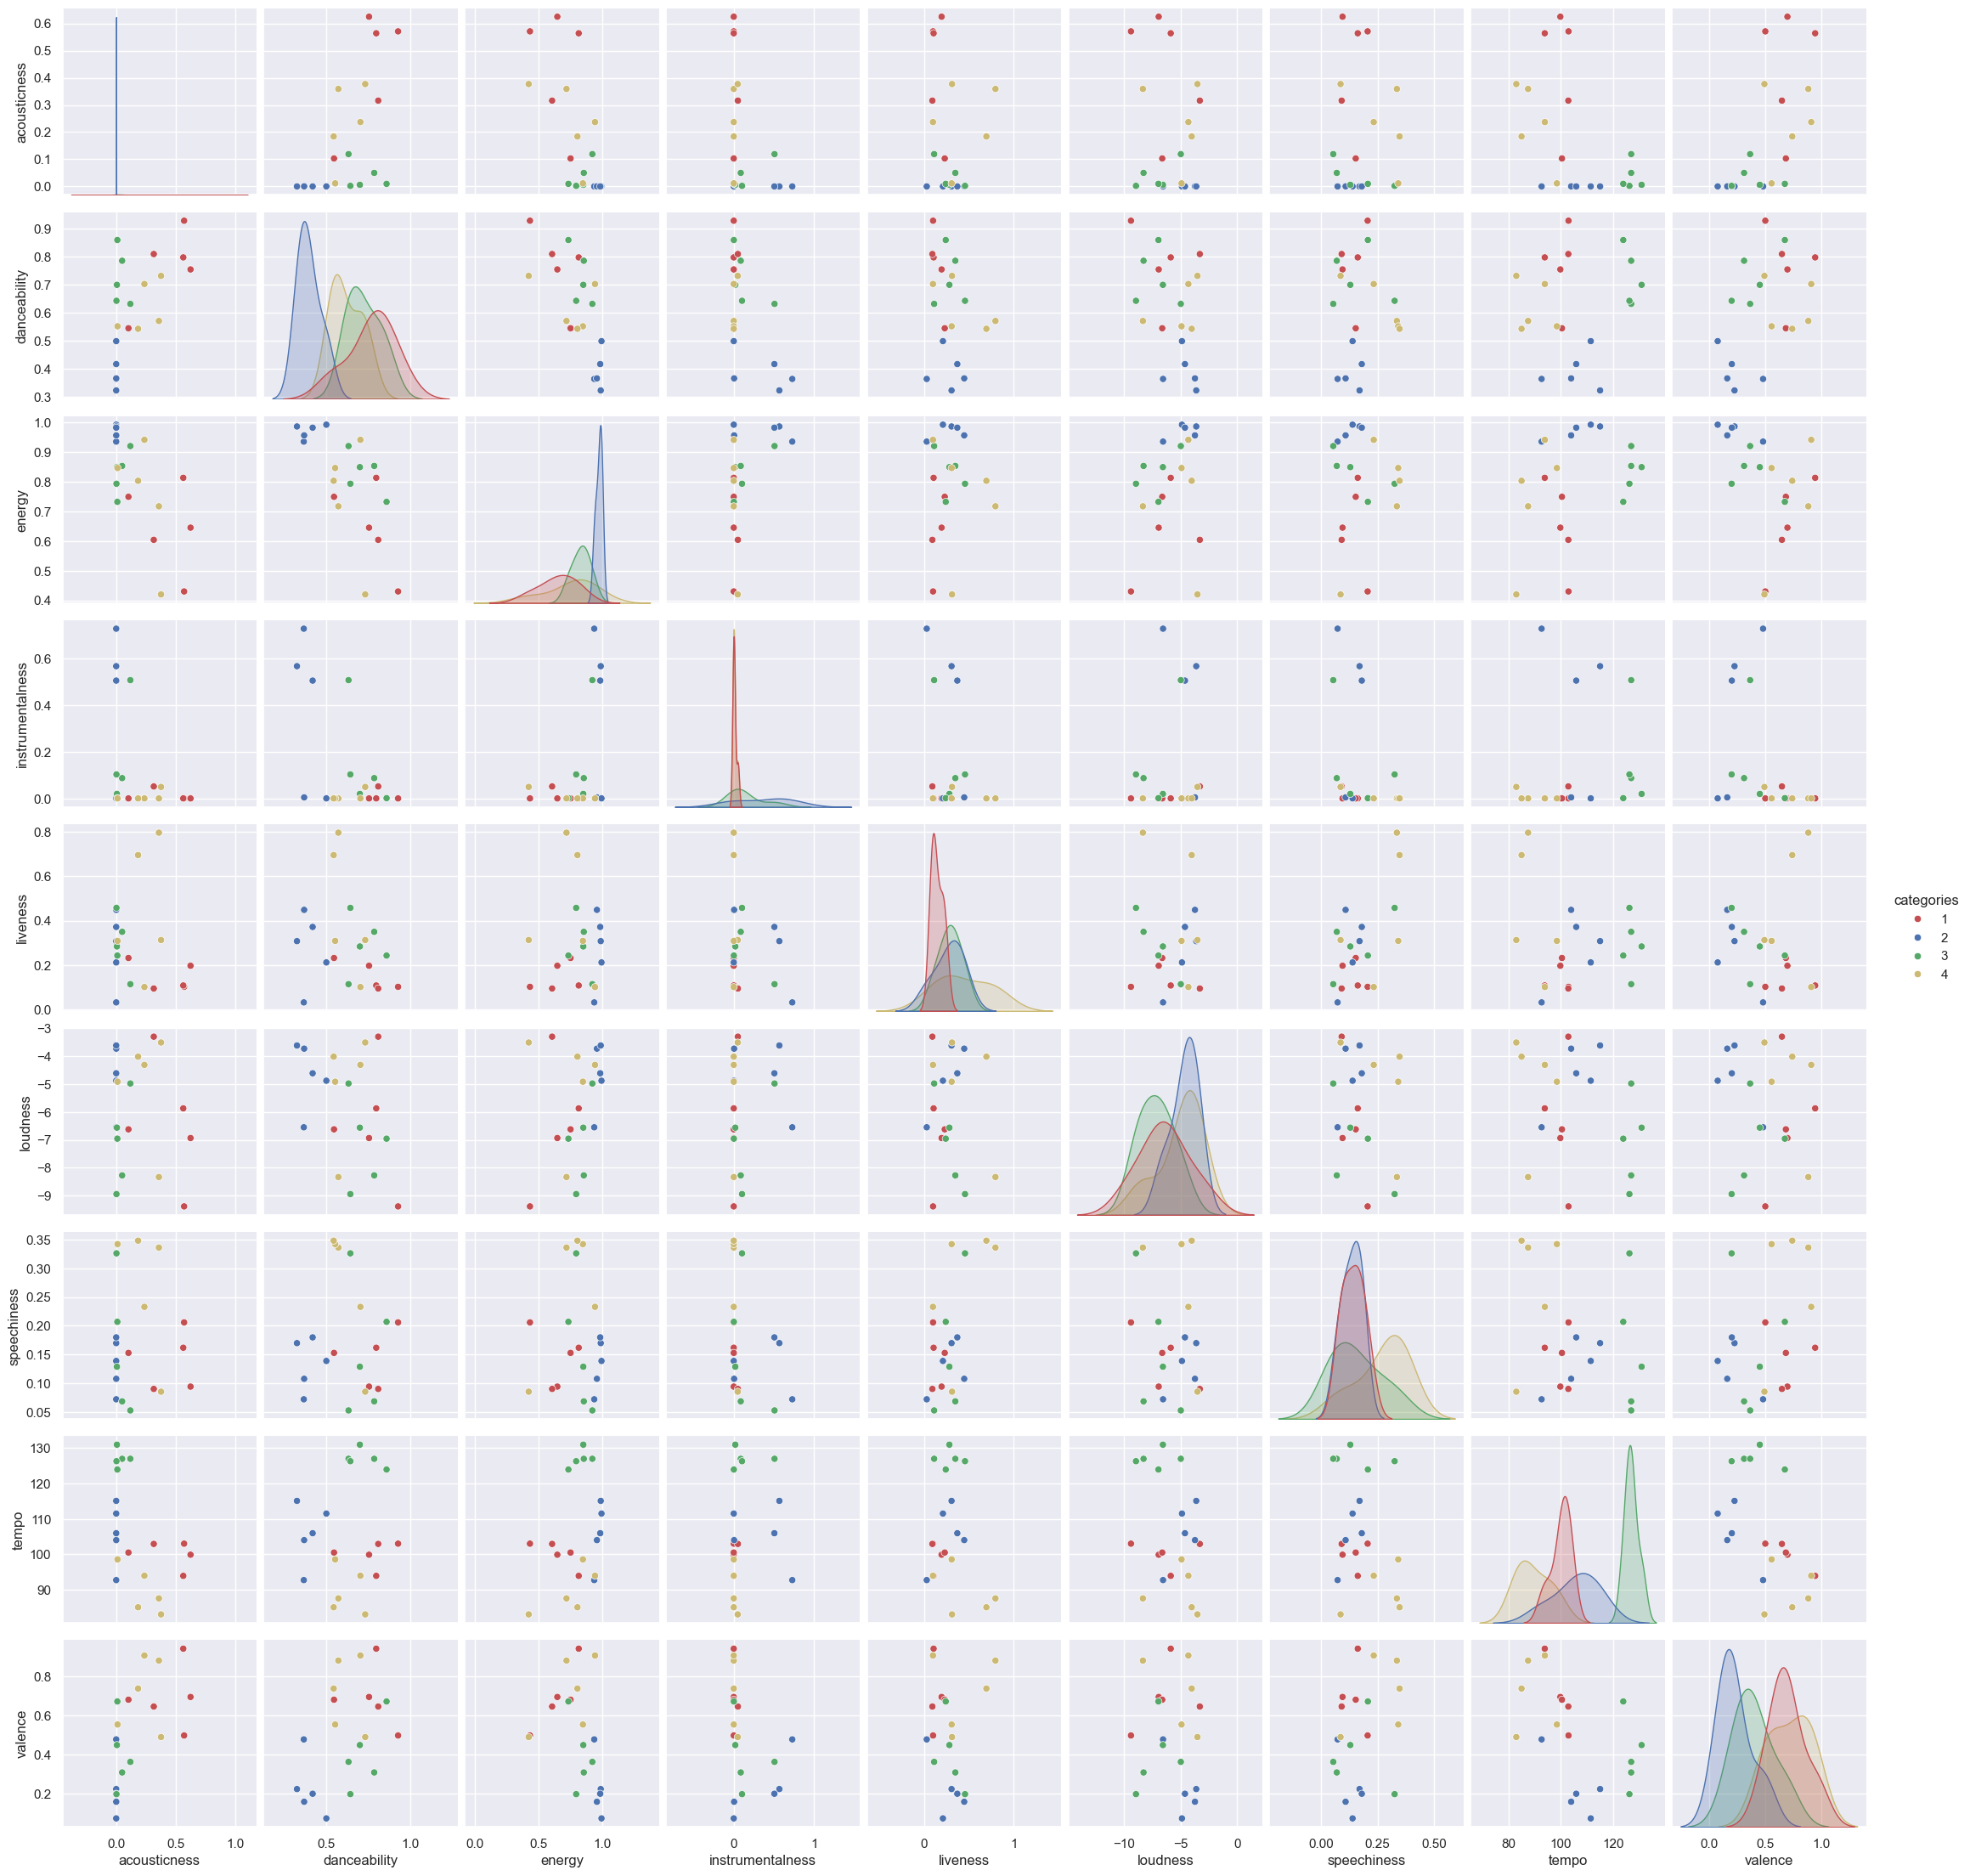

In [11]:
non_features = ['name', 'artist', 'track_URI', 'playlist']
track_info = df[non_features]
df_X = df.drop(columns=non_features)
df_X

sns.pairplot(df_X, vars=df_X.columns[:-1], hue="categories", palette={1:'r', 2:'b', 3:'g', 4:'y'})

In [12]:
# Below train_categories has all features, the clustering output is not great
# train_categories = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# With these set of training variables, we get a much better output
train_categories = ['acousticness', 'danceability', 'energy', 'tempo', 'valence']
# Set this to control the number of data points to be used
n = 20

df_X_train = df_X[train_categories][:n]
df_X_train

,acousticness,danceability,energy,tempo,valence
0,0.571000,0.929,0.430,103.0100,0.498
1,0.564000,0.798,0.813,93.9120,0.942
2,0.625000,0.755,0.645,99.8890,0.695
3,0.316000,0.810,0.604,102.9370,0.646
4,0.103000,0.545,0.749,100.5030,0.681
5,0.000009,0.364,0.935,92.7170,0.478
6,0.000293,0.366,0.956,104.0160,0.159
7,0.000113,0.499,0.992,111.5180,0.074
8,0.000019,0.323,0.986,115.1070,0.224
9,0.000009,0.417,0.982,105.9620,0.200


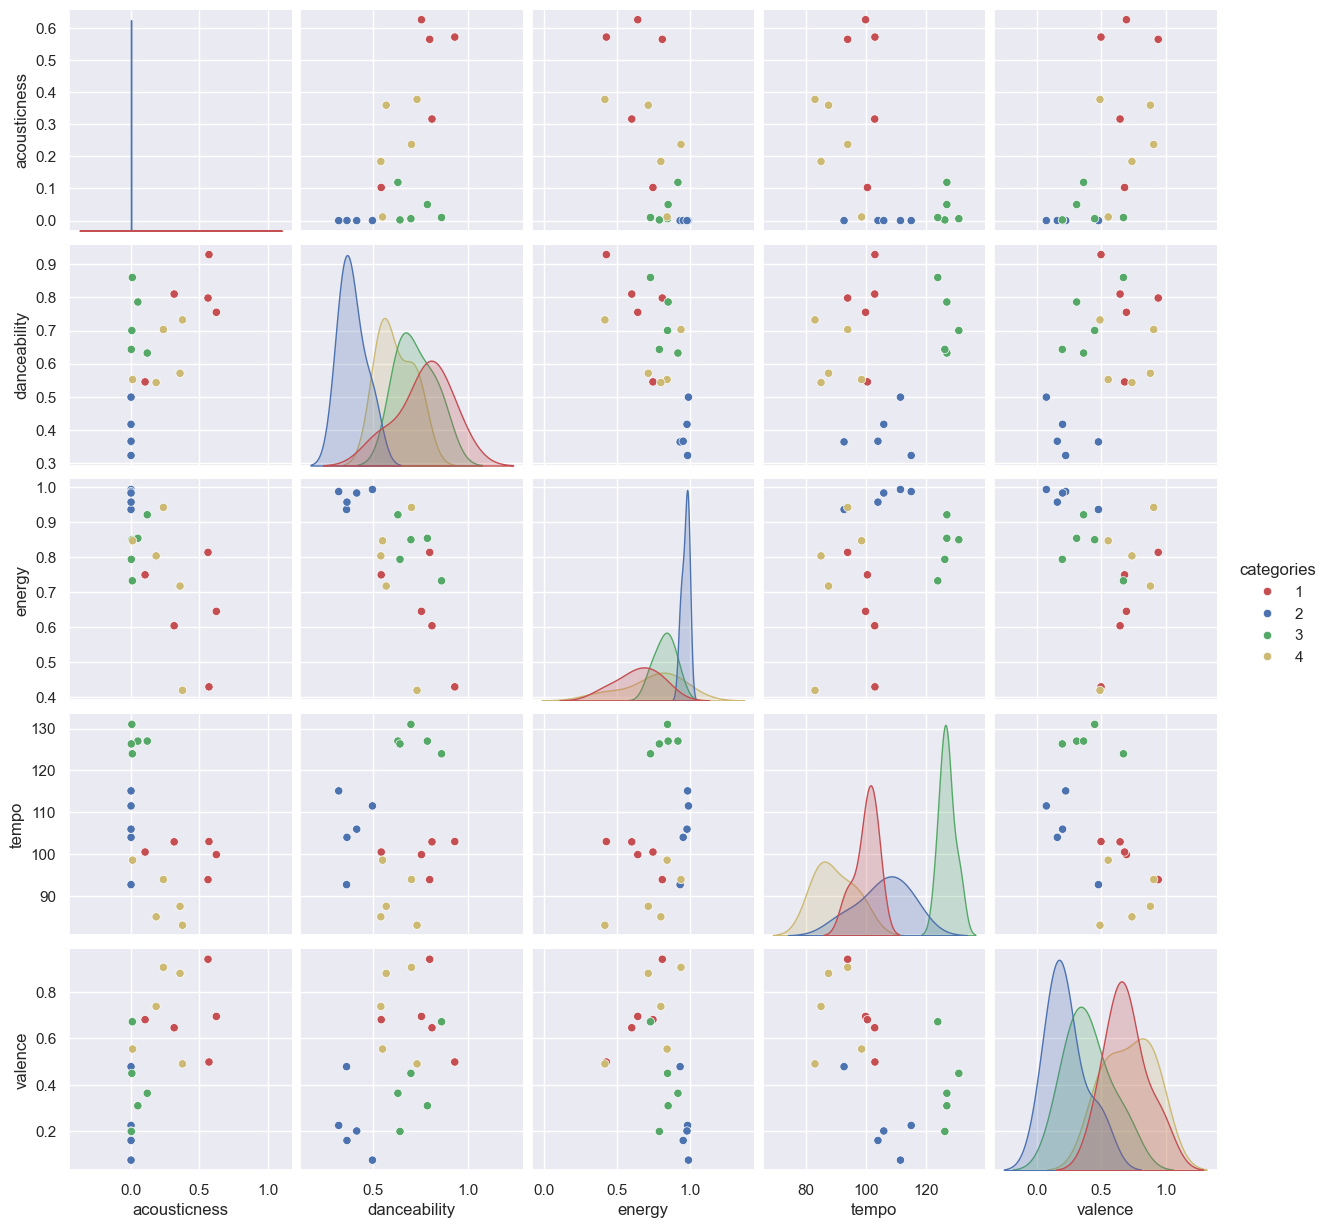

In [13]:
sns.pairplot(df_X[:n], vars=train_categories, hue="categories", palette={1:'r', 2:'b', 3:'g', 4:'y'})

## Scaling the Data

In [14]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X_train)

## K-Means Clustering

### Finding the elbow point of the WCSS (within cluster sum of squares) curve 

In [15]:
maxclusters = 10
wcss = []
for i in range(1, maxclusters+1):
    kmeans = KMeans(n_clusters = i, n_init=4, init = 'k-means++', random_state = 42)
    kmeans.fit(X_std)
    wcss.append(kmeans.inertia_)

### Finding Optimal Number of Clusters

Optimal number of clusters 4


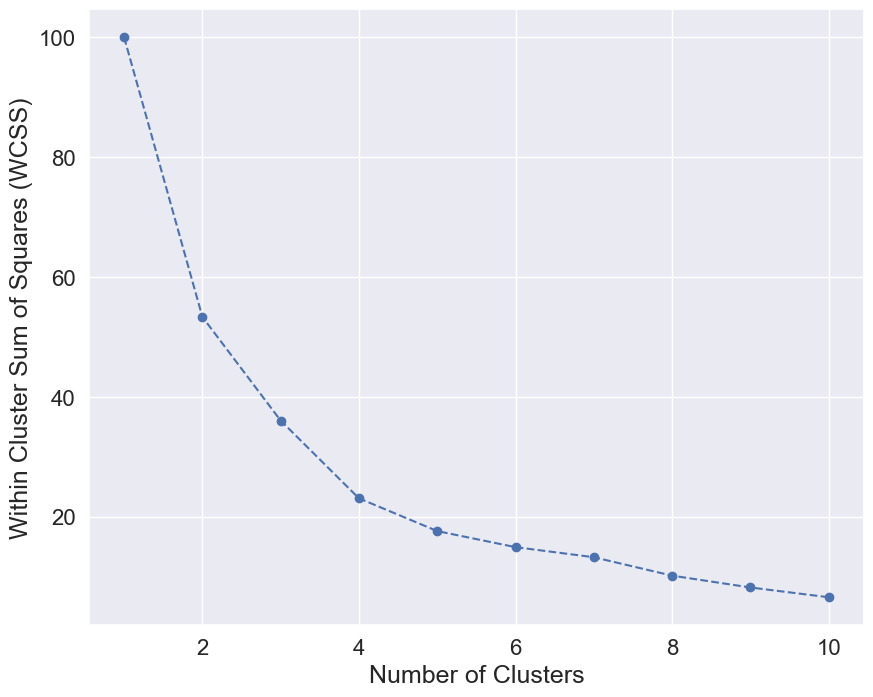

In [16]:
n_clusters = KneeLocator([i for i in range(1, maxclusters+1)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)
    
# Display the WCSS curve
    
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, maxclusters+1), wcss, marker='o', linestyle='--')
# plt.vlines(n_clusters, ymin=0, ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Clustering using the optimal k found

In [17]:
# Import KMeans
from sklearn.cluster import KMeans

# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters=n_clusters, n_init=4)
# Fit model to points
model.fit(X_std)
# Determine the cluster labels of new_points: labels
labels = model.predict(X_std)


### Pairwise Scatter Plots with Centroids

## Analysis

In [18]:
## Drop irrelevant columns
nf = ['track_URI', 'playlist']
df_cl = df[:n].drop(columns=nf)

## Add predicted labels and display the dataframe
df_cl['Cluster'] = labels
df_cl

,name,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,categories,Cluster
0,Talibans,Byron Messia,0.571000,0.929,0.430,0.000000,0.1020,-9.387,0.2060,103.0100,0.498,1,2
1,Gbona,Burna Boy,0.564000,0.798,0.813,0.000142,0.1080,-5.869,0.1620,93.9120,0.942,1,2
2,"PAMI (feat. Wizkid, Adekunle Gold & Omah Lay)",DJ Tunez,0.625000,0.755,0.645,0.000006,0.1970,-6.933,0.0944,99.8890,0.695,1,2
3,Pull Up,Koffee,0.316000,0.810,0.604,0.051400,0.0944,-3.296,0.0904,102.9370,0.646,1,2
4,Ginger (feat. Burna Boy),Wizkid,0.103000,0.545,0.749,0.000000,0.2320,-6.621,0.1530,100.5030,0.681,1,1
5,Blood and Thunder,Mastodon,0.000009,0.364,0.935,0.729000,0.0317,-6.548,0.0724,92.7170,0.478,2,3
6,Laid to Rest,Lamb of God,0.000293,0.366,0.956,0.004470,0.4490,-3.725,0.1080,104.0160,0.159,2,3
7,Re-Crucified,Revocation,0.000113,0.499,0.992,0.000265,0.2120,-4.876,0.1390,111.5180,0.074,2,3
8,Lifestalker,Cattle Decapitation,0.000019,0.323,0.986,0.568000,0.3080,-3.612,0.1700,115.1070,0.224,2,3
9,As Grace Descends,Suffocation,0.000009,0.417,0.982,0.506000,0.3720,-4.609,0.1800,105.9620,0.200,2,3


## Plot Kmeans output

In [19]:
## Apply PCA on feature vectors to reduce to 2D, and visualize Kmeans output
## https://www.askpython.com/python/examples/plot-k-means-clusters-python

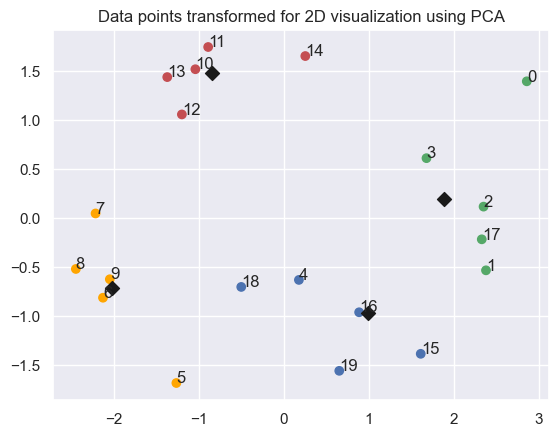

In [20]:
from sklearn.decomposition import PCA
 
# Set PCA dimensions
pca = PCA(2)

# Transform the data
df_X_2d = pca.fit_transform(X_std)

# Plot on 2D scale
xs = df_X_2d[:,0]
ys = df_X_2d[:,1]

# Make a scatter plot of xs and ys, using labels to define the colors
palette={1:'r', 2:'b', 3:'g', 4:'orange'}
colors = list(map(lambda x: palette[x], labels+1))
plt.scatter(xs,ys,c=colors, alpha=1)
plt.title("Data points transformed for 2D visualization using PCA")

# Label all the data points
ctr=0
centroid_x = 0
centroid_y = 0

for (l, m) in zip(xs, ys):
    plt.text(l,m,ctr)
    ctr+=1
    
    # Calculating centroids manually, instead of applying the PCA transform to higher dim predictions
    centroid_x+=l
    centroid_y+=m
    
    if ctr%5==0:
        plt.scatter(centroid_x/5,centroid_y/5,marker='D', color='k', s=50)
        centroid_x = 0
        centroid_y = 0

# Experiment with PCA and K-Means

In [21]:
def PCA2D_KMeans(X, train_categories, title="", n=20):
    """Scale input features, reduce to 2 dimensions using PCA, do K-means clustering and show scatter plots
    
    Args:
            X (Pandas DF): Input features
            train_categories (list): subset of features to use
            title (string): Plot Title
            n (int): Number of data points to use
            
    Result:
            Scatter Plot color coded with K-means clusters, and cluster centroids marked
            
    """
    
    ## Scale feature vectors to standard normal
    X_std = StandardScaler().fit_transform(X[train_categories][:n])
    
    ## Apply 2D PCA
    X_2d = PCA(2).fit_transform(X_std)
    
    ## K-means directly on PCA applied features

    # Create a KMeans instance with 4 clusters
    model_2d = KMeans(n_clusters=4, n_init=4)
    # Fit model to points
    model_2d.fit(X_2d)
    # Determine the cluster labels of new_points: labels
    labels_2d = model_2d.predict(X_2d)
    
    
    # Plot on 2D scale
    xs = X_2d[:,0]
    ys = X_2d[:,1]

    # Make a scatter plot of xs and ys, using labels to define the colors
    palette={1:'r', 2:'b', 3:'g', 4:'orange'}
    colors = list(map(lambda x: palette[x], labels_2d+1))
    plt.scatter(xs,ys,c=colors, alpha=1)
    plt.title(title)
    
    ctr=0
    for (l, m) in zip(xs, ys):
        plt.text(l,m,ctr)
        ctr+=1
    
    # Assign the cluster centers: centroids
    centroids = model_2d.cluster_centers_

    # Assign the columns of centroids: centroids_x, centroids_y
    centroids_x = centroids[:,0]
    centroids_y = centroids[:,1]

    # Make a scatter plot of centroids_x and centroids_y
    plt.scatter(centroids_x,centroids_y,marker='D', color='k', s=50, alpha=0.5)
    plt.show()    
    
    

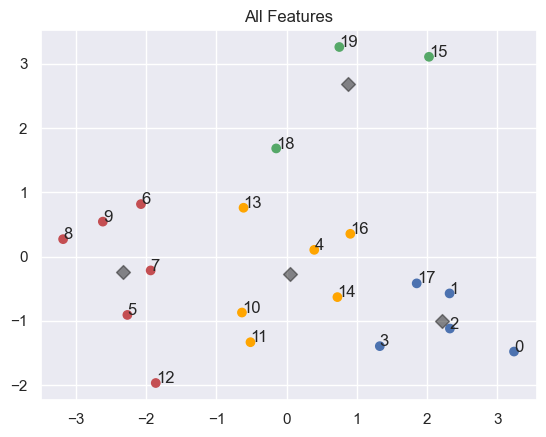

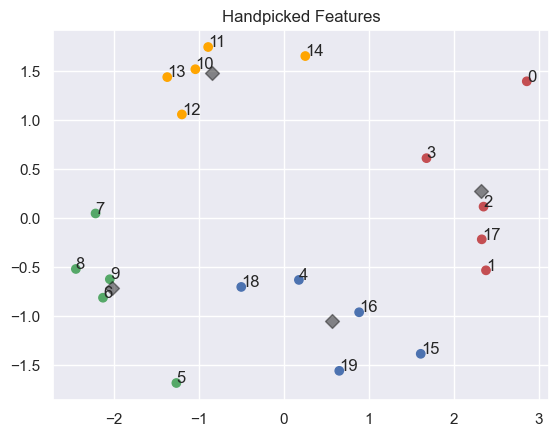

In [22]:
train_cat_all = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
train_cat_sub = ['acousticness', 'danceability', 'energy', 'tempo', 'valence']

# Set this to control the number of data points to be used
n = 20

PCA2D_KMeans(df_X, train_cat_all, "All Features")
PCA2D_KMeans(df_X, train_cat_sub, "Handpicked Features")